In [1]:
# Reference:
# /exp/rhuang/icefall_align2/egs/librispeech/ASR/ruizhe_hmm/run.ipynb
# /exp/rhuang/icefall_align2/icefall/bpe_graph_compiler.py

In [25]:
import sys
sys.path.insert(0,'/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg')
sys.path.insert(0,'/exp/rhuang/meta/k2/k2/python')
sys.path.insert(0,'/exp/rhuang/meta/k2/temp.linux-x86_64-cpython-310/lib')
sys.path.insert(0,'/exp/rhuang/meta/icefall')

In [26]:
import k2
import sentencepiece as spm
import torch
import pywrapfst as openfst

In [27]:
sp = spm.SentencePieceProcessor()
sp.load("/exp/rhuang/meta/icefall/egs/librispeech/ASR/data/lang_bpe_500/bpe.model")

True

In [28]:
texts = ["I DO NOT WANT TO INCUR", "THERE WAS LOVERS LIKE DOGS", "RED APP I"]
word_ids_list = sp.encode(texts, out_type=int)
word_ids_list

[[19, 100, 69, 414, 10, 15, 18, 79],
 [153, 33, 370, 23, 3, 231, 100, 52, 3],
 [49, 12, 5, 145, 19]]

In [29]:
word_ids_list = [[24, 102, 70, 393, 12, 17, 19, 80], [154, 37, 345, 21, 3, 225, 102, 52, 3]]
word_ids_list = [[24, 102, 70, 393, 12, 12, 17, 19, 80], [154, 37, 345, 21, 3, 225, 102, 52, 3]]
word_ids_list = [[24, 102, 70]]
word_ids_list = [[49, 11, 7, 161, 24]]
word_ids_list = [[414, 3, 10], [4, 23, 174, 24], [49, 12, 5, 145, 19]]

In [30]:
graphs = k2.ctc_graph(word_ids_list, modified=False, device='cpu')

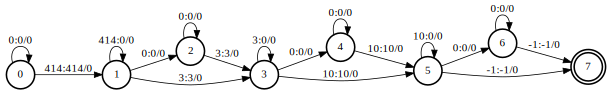

In [31]:
k2.to_dot(graphs[0])

In [32]:
graph = graphs[0]
c_str = k2.to_str_simple(graph)

In [10]:
arcs = c_str.strip().split("\n")
arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
final_state = int(arcs[-1])
arcs = arcs[:-1]
arcs = [tuple(map(int, a.split())) for a in arcs]

In [11]:
arcs

[(0, 0, 0, 0, 0),
 (0, 1, 414, 414, 0),
 (1, 2, 0, 0, 0),
 (1, 1, 414, 0, 0),
 (1, 3, 3, 3, 0),
 (2, 2, 0, 0, 0),
 (2, 3, 3, 3, 0),
 (3, 4, 0, 0, 0),
 (3, 3, 3, 0, 0),
 (3, 5, 10, 10, 0),
 (4, 4, 0, 0, 0),
 (4, 5, 10, 10, 0),
 (5, 6, 0, 0, 0),
 (5, 5, 10, 0, 0),
 (5, 7, -1, -1, 0),
 (6, 6, 0, 0, 0),
 (6, 7, -1, -1, 0)]

In [12]:
def make_factor_transducer1(word_id_list):
    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0)   # if this node has a non-eps in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    arcs += [(n, final_state, -1, -1, 0) for n in range(1, final_state - 2)]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst


In [13]:
def make_factor_transducer2(word_id_list, return_str=False, blank_penalty=-1):
    # This is the factor transducer where blank symbols at the beginning and ending of the graph is penalized
    # Last resort: use a cheap alignment model to get a subgraph of the big graph first

    # blank_penalty should be negative

    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    arc0 = arcs[0]
    arcs_last = [a for a in arcs[-5:] if a[2] > 0]

    arcs = [(0, 0, 0, 0, blank_penalty)] + arcs[1:-5] + arcs_last

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0)   # if this node has a non-eps in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    # arcs += [(n, final_state, -1, -1, 0) for n in range(1, final_state - 2)]
    arcs += [(n, final_state - 1, 0, 0, blank_penalty) for n, l in non_eps_nodes]
    arcs += [(final_state - 1, final_state - 1, 0, 0, blank_penalty)]
    arcs += [(final_state - 1, final_state, -1, -1, 0)]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    if return_str:
        return new_arcs
    else:
        fst = k2.Fsa.from_str(new_arcs, acceptor=False)
        return fst

In [14]:
def make_factor_transducer3(word_id_list, word_start_symbols):
    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    non_eps_nodes2 = set((arc[0], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start out-going arc
    non_eps_nodes2 = [(n, l) for n, l in non_eps_nodes2 if 0 < n < final_state - 2]
    arcs += [(n, final_state, -1, -1, 0) for n, l in non_eps_nodes2]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst


In [15]:
class MyCounter: 
    def __init__(self): self.counter1 = 0; self.counter2 = 1; self.counter2_ = 0
    # def __call__(self): self.counter += 1; return self.counter
    def f1(self): 
        self.counter1 += 1; return self.counter1
    def f2(self): 
        self.counter2_ += 1; 
        if self.counter2_ % 2 == 1: self.counter2 += 1; 
        return self.counter2


def make_factor_transducer4(word_id_list, word_start_symbols):
    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    counter = MyCounter()

    non_eps_nodes1 = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start in-coming arc
    non_eps_nodes1 = sorted(non_eps_nodes1, key=lambda x: x[0])
    non_eps_nodes2 = list((arc[0], arc[1]) for arc in arcs if arc[3] < 0 or (arc[3] > 0 and arc[3] in word_start_symbols and arc[0] > 0))   # if this node has a non-eps, word-start out-going arc
    self_loops = {ss: l1 for ss, ee, l1, l2, w in arcs if ss == ee}

    arcs = [arcs[0]] + arcs[2:-5] + [a for a in arcs[-5:] if a[2] >= 0]
    arcs = [[ss, ee, l1, 0, w] for ss, ee, l1, l2, w in arcs]
    arcs += [(0, n, l, counter.f1(), 0) for n, l in non_eps_nodes1]
    arcs += [(n, final_state, self_loops[n], counter.f2(), 0) for n, l in non_eps_nodes2]
    arcs += [(final_state, final_state + 1, -1, -1, 0)]
    
    # non_eps_nodes2 = [(n, l) for n, l in non_eps_nodes2 if 0 < n < final_state - 2]
    
    new_arcs = arcs
    new_arcs.append([final_state + 1])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    # print(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst

In [37]:
def _make_factor_transducer5(fst_graphs_3, word_start_symbols, two_ends_bonus=1.0):
    # This is similar to make_factor_transducer3
    # We concat three graphs, and then add some bonus to the two ends of the graph to encourage alignment to the two ends
    # We will probably also do non-linear scaling

    # Compared to make_factor_transducer3, we remove some arcs from the graph
    # Also, we modify some arcs to add bonus to the two ends of the graph to encourage alignment to the two ends

    ############ Graph 1 ############
    fst_graph1 = fst_graphs_3[0]
    
    c_str = k2.to_str_simple(fst_graph1)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])

    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    # boost the weights
    arcs = [(ss, ee, l1, l2, w + two_ends_bonus) if (ss>0 and l1>0) else (ss, ee, l1, l2, w + two_ends_bonus * 5) if (ee>0 and l1>0) else (ss, ee, l1, l2, w) for ss, ee, l1, l2, w in arcs]

    arcs += [(0, final_state, -1, -1, 0)]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst_graph1 = k2.Fsa.from_str(new_arcs, acceptor=False)

    ############ Graph 2 ############
    fst_graph2 = fst_graphs_3[1]

    ############ Graph 3 ############
    fst_graph3 = fst_graphs_3[2]

    c_str = k2.to_str_simple(fst_graph3)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])

    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    non_eps_nodes2 = set((arc[0], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start out-going arc
    non_eps_nodes2 = [(n, l) for n, l in non_eps_nodes2 if 0 < n < final_state - 2]
    arcs += [(n, final_state, -1, -1, 0) for n, l in non_eps_nodes2]

    # boost the weights
    arcs = [(ss, ee, l1, l2, w + two_ends_bonus) if (ee!=final_state and l1>0) else (ss, ee, l1, l2, w + two_ends_bonus*5) if l1>0 else (ss, ee, l1, l2, w) for ss, ee, l1, l2, w in arcs]

    arcs += [(0, final_state, -1, -1, 0)]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst_graph3 = k2.Fsa.from_str(new_arcs, acceptor=False)

    # concatenate the three graphs: don't be fooled by `k2.cat`
    compiler = openfst.Compiler()
    compiler.write(k2.to_str_simple(fst_graph1, openfst=True))
    f1 = compiler.compile()
    compiler.write(k2.to_str_simple(fst_graph2, openfst=True))
    f2 = compiler.compile()
    compiler.write(k2.to_str_simple(fst_graph3, openfst=True))
    f3 = compiler.compile()
    f1.concat(f2)
    f1.concat(f3)
    fst = k2.Fsa.from_openfst(str(f1), acceptor=False)
    return fst


In [39]:
# [sp.id_to_piece(i) for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')]
word_start_symbols = [i for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')]

In [41]:
# graph_ft = make_factor_transducer1(word_ids_list[0])
# graph_ft = make_factor_transducer2(word_ids_list[0])
# graph_ft = make_factor_transducer3(word_ids_list[0], word_start_symbols=[i for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')])
# graph_ft = make_factor_transducer4(word_ids_list[0], word_start_symbols=[i for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')])
graph_ft = _make_factor_transducer5(graphs, word_start_symbols=word_start_symbols, two_ends_bonus=1.3)

In [42]:
graph_ft.arcs.values()

tensor([[          0,           0,           0, -2147483648],
        [          0,           1,         414,  1087373312],
        [          0,           2,          10,  1087373312],
        [          0,           7,           0, -2147483648],
        [          1,           3,           0, -2147483648],
        [          1,           1,         414,  1067869798],
        [          1,           4,           3,  1067869798],
        [          2,           6,           0, -2147483648],
        [          2,           2,          10,  1067869798],
        [          2,           7,           0, -2147483648],
        [          3,           3,           0, -2147483648],
        [          3,           4,           3,  1067869798],
        [          4,           5,           0, -2147483648],
        [          4,           4,           3,  1067869798],
        [          4,           2,          10,  1067869798],
        [          5,           5,           0, -2147483648],
        

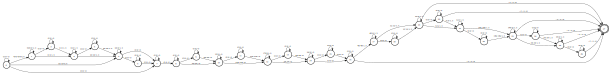

In [43]:
k2.to_dot(graph_ft)

In [21]:
graph_ft.labels

tensor([  0, 414,  10,  -1,   0, 414,   3,   0,   3,   0,   3,  10,   0,  10,
          0,  10,  -1,   0,  -1], dtype=torch.int32)

In [22]:
graph_ft.aux_labels

tensor([  0, 414,  10,  -1,   0,   0,   3,   0,   3,   0,   0,  10,   0,  10,
          0,   0,  -1,   0,  -1], dtype=torch.int32)

In [23]:
fst = k2.random_fsa(max_symbol=20, acyclic=True, min_num_arcs=10, max_num_arcs=100)
# fst = k2.random_fsa_vec()
fst.shape, fst.num_arcs

((3, None), 16)

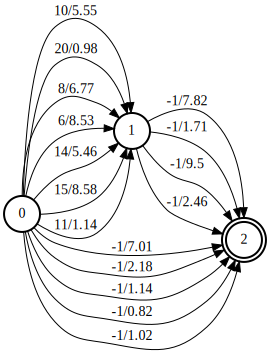

In [24]:
k2.to_dot(fst)

In [25]:
fst.labels

tensor([10, 20, -1, -1, -1,  8,  6, -1, 14, 15, 11, -1, -1, -1, -1, -1],
       dtype=torch.int32)

In [26]:
aux_labels = torch.randint(0, 20, (fst.labels.size(0), 2))
# fst.aux_labels = aux_labels
# fst.aux_labels

In [27]:
# path = k2.random_paths(k2.create_fsa_vec([fst]), use_double_scores=True, num_paths=1)[0]
path = k2.shortest_path(k2.create_fsa_vec([fst]), use_double_scores=True)[0]
path.shape, path.num_arcs

((3, None), 2)

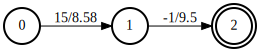

In [28]:
k2.to_dot(path)

In [29]:
path.labels

tensor([15, -1], dtype=torch.int32)

In [30]:
path.aux_labels

AttributeError: Unknown attribute aux_labels

In [31]:
# https://github.com/k2-fsa/k2/blob/master/k2/python/k2/utils.py#L211
fst.arcs.values()

tensor([[         0,          1,         10, 1085381055],
        [         0,          1,         20, 1065068548],
        [         0,          2,         -1, 1088441199],
        [         0,          2,         -1, 1074503273],
        [         0,          2,         -1, 1066516792],
        [         0,          1,          8, 1087936754],
        [         0,          1,          6, 1091074952],
        [         0,          2,         -1, 1062343579],
        [         0,          1,         14, 1085201014],
        [         0,          1,         15, 1091121996],
        [         0,          1,         11, 1066508999],
        [         0,          2,         -1, 1065541966],
        [         1,          2,         -1, 1090141593],
        [         1,          2,         -1, 1071340503],
        [         1,          2,         -1, 1092094871],
        [         1,          2,         -1, 1075668090]], dtype=torch.int32)

In [32]:
fst_dict = fst.as_dict()
fst_dict

{'arcs': tensor([[         0,          1,         10, 1085381055],
         [         0,          1,         20, 1065068548],
         [         0,          2,         -1, 1088441199],
         [         0,          2,         -1, 1074503273],
         [         0,          2,         -1, 1066516792],
         [         0,          1,          8, 1087936754],
         [         0,          1,          6, 1091074952],
         [         0,          2,         -1, 1062343579],
         [         0,          1,         14, 1085201014],
         [         0,          1,         15, 1091121996],
         [         0,          1,         11, 1066508999],
         [         0,          2,         -1, 1065541966],
         [         1,          2,         -1, 1090141593],
         [         1,          2,         -1, 1071340503],
         [         1,          2,         -1, 1092094871],
         [         1,          2,         -1, 1075668090]], dtype=torch.int32)}

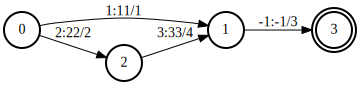

In [33]:
s = '''
0 1 1 11 1
0 2 2 22 2
1 3 -1 -1 3
2 1 3 33 4
3
'''
fsa = k2.Fsa.from_str(s, acceptor=False)
k2.to_dot(fsa)

In [34]:
from kaldifst.utils import k2_to_openfst

In [35]:
k2_to_openfst(fsa)

In [36]:
k2.to_str_simple(fsa, openfst=True)

'0 1 1 11 -1\n0 2 2 22 -2\n1 -3\n2 1 3 33 -4\n'

In [37]:
dir(fst)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_get_arc_cdf',
 '_get_arc_post',
 '_get_backward_scores',
 '_get_dest_states',
 '_get_entering_arc_batches',
 '_get_entering_arcs',
 '_get_forward_scores',
 '_get_incoming_arcs',
 '_get_leaving_arc_batches',
 '_get_state_batches',
 '_get_tot_scores',
 '_invalidate_cache_',
 '_non_tensor_attr',
 '_properties',
 '_tensor_attr',
 'arcs',
 'arcs_as_tensor',
 'as_dict',
 'clone',
 'convert_attr_to_ragged_',
 'detach',
 'device',
 'draw',
 'from_dict',
 'from_fsas',
 'from_openfst',
 'from_str',
 'get_arc_post',
 'get_backward_scores',
 'get_filler',
 'get_forward_scores',
 'get_tot_s

## OpenFST python wrapper

https://www.openfst.org/twiki/bin/view/FST/PythonExtension


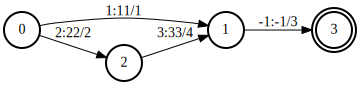

In [2]:
import k2

s = '''
0 1 1 11 1
0 2 2 22 2
1 3 -1 -1 3
2 1 3 33 4
3
'''
fsa = k2.Fsa.from_str(s, acceptor=False)
k2.to_dot(fsa)

In [3]:
k2.to_str_simple(fsa, openfst=True)

'0 1 1 11 -1\n0 2 2 22 -2\n1 -3\n2 1 3 33 -4\n'

In [4]:
import pywrapfst as fst

# Create a simple FST
compiler1 = fst.Compiler()
compiler1.write(k2.to_str_simple(fsa, openfst=True))
f1 = compiler1.compile()

compiler2 = fst.Compiler()
compiler2.write(k2.to_str_simple(fsa, openfst=True))
f2 = compiler2.compile()

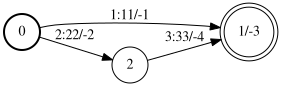

In [5]:
f1

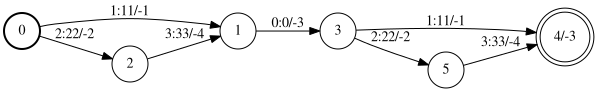

In [6]:
f1.concat(f2)

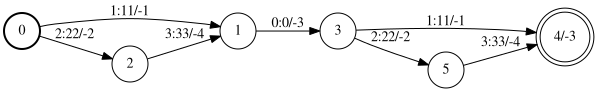

In [10]:
f1

In [7]:
help(fst.Fst.read_from_string)

Help on built-in function read_from_string:

read_from_string(...) method of builtins.type instance
    read_from_string(state)
    
    Reads an FST from a serialized string.
    
    Args:
      state: A string containing the serialized FST.
    
    Returns:
      An FST object.
    
    Raises:
      FstIOError: Read failed.



In [9]:
str(f1)

'0\t1\t1\t11\t-1\n0\t2\t2\t22\t-2\n1\t3\t0\t0\t-3\n2\t1\t3\t33\t-4\n3\t4\t1\t11\t-1\n3\t5\t2\t22\t-2\n4\t-3\n5\t4\t3\t33\t-4\n'

In [12]:
fsa_ = k2.Fsa.from_str(str(f1), acceptor=False, openfst=True)

In [15]:
fsa_ = k2.Fsa.from_openfst(str(f1), acceptor=False)

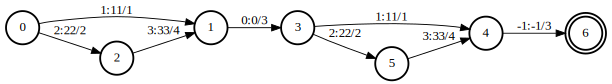

In [16]:
k2.to_dot(fsa_)

In [18]:
compiler1 = fst.Compiler()
compiler1.write(k2.to_str_simple(fsa, openfst=True))
f1 = compiler1.compile()

In [33]:
compiler1.write(k2.to_str_simple(graph, openfst=True))
f2 = compiler1.compile()

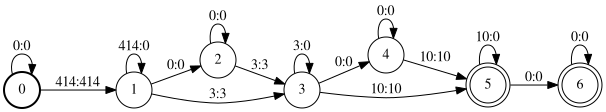

In [36]:
f2